In [1]:
from __future__ import division, print_function
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import glob
from imageio import imread, imsave
from mpl_toolkits.axes_grid1 import ImageGrid

from skimage.color import rgb2gray
import skimage.io as io
from skimage.feature import plot_matches

# Homework 4

I referred to several examples on skimage's official site:

- [ORB](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_orb.html#sphx-glr-auto-examples-features-detection-plot-orb-py)
- [RANSAC](https://scikit-image.org/docs/dev/auto_examples/transform/plot_matching.html#sphx-glr-auto-examples-transform-plot-matching-py)

[Notebook on ProjectiveTransform with RANSAC](https://notebook.community/scikit-image/skimage-demos/pano/pano-advanced)

In [2]:
def plot_imageset(images, figsize=(12, 10)):
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.1)

    for ax, im in zip(grid, images):
        ax.set_axis_off()
        if len(im.shape) < 3:
            ax.imshow(im, cmap='gray')
        else:
            ax.imshow(im)

    plt.show()

### Load and preprocess images

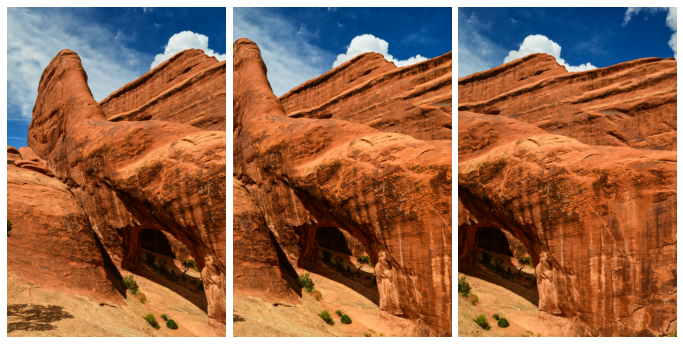

In [5]:
pano_paths = sorted(glob.glob('data/JDW_03*'))

pano_imgs = [imread(path) for path in pano_paths]

plot_imageset(pano_imgs)

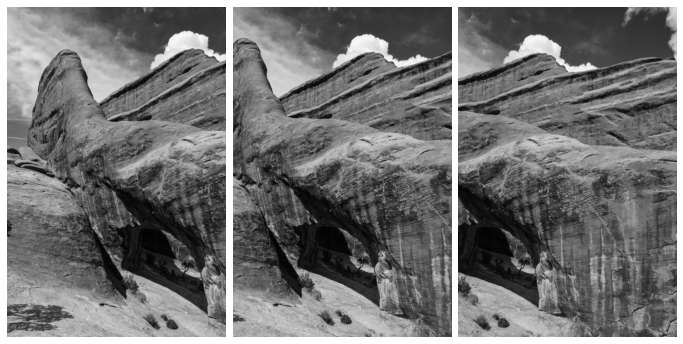

In [4]:
# Convert to grayscale
pano0, pano1, pano2 = [rgb2gray(im) for im in pano_imgs]
plot_imageset([pano0, pano1, pano2])

# Detect features and plot matches

In [6]:
from skimage.feature import ORB

# skimage
orb = ORB(n_keypoints=800, fast_threshold=0.05)

# cv2 
# orb = cv2.ORB_create()
# sift = cv2.SIFT_create()

# skimage
orb.detect_and_extract(pano0)
keypoints0 = orb.keypoints
descriptors0 = orb.descriptors

orb.detect_and_extract(pano1)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

orb.detect_and_extract(pano2)
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors

# cv2
# keypoints0, descriptors0 = orb.detectAndCompute(pano0, None)

In [15]:
# Match the descriptors 
# do this for both 0->1 and 2->1

# skimage: from skimage.feature import match_descriptors
# opencv: easiest is probably cv2.BFMatcher

from skimage.feature import match_descriptors, plot_matches

matches01 = match_descriptors(descriptors0, descriptors1, 
                              cross_check=True)
matches21 = match_descriptors(descriptors2, descriptors1, 
                              cross_check=True)

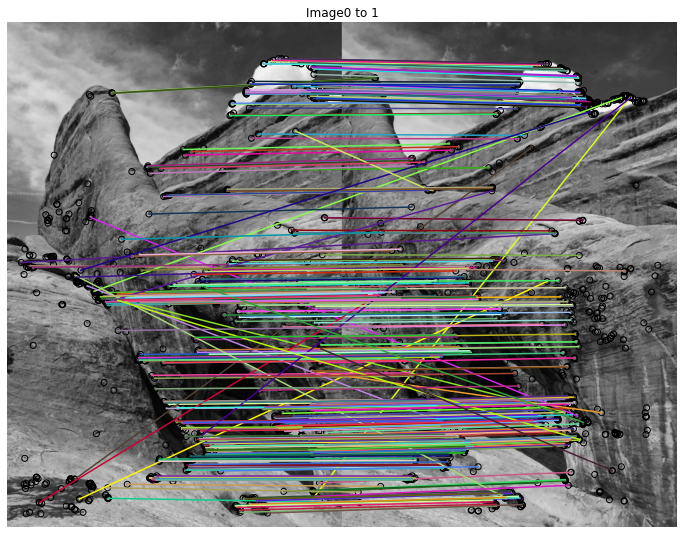

In [18]:
plt.figure(figsize=(12, 10))
plt.axis('off')
plt.gray()
plt.title('Image0 to 1')
ax = plt.gca()
plot_matches(ax, pano0, pano1, keypoints0, keypoints1, matches01)
plt.show()

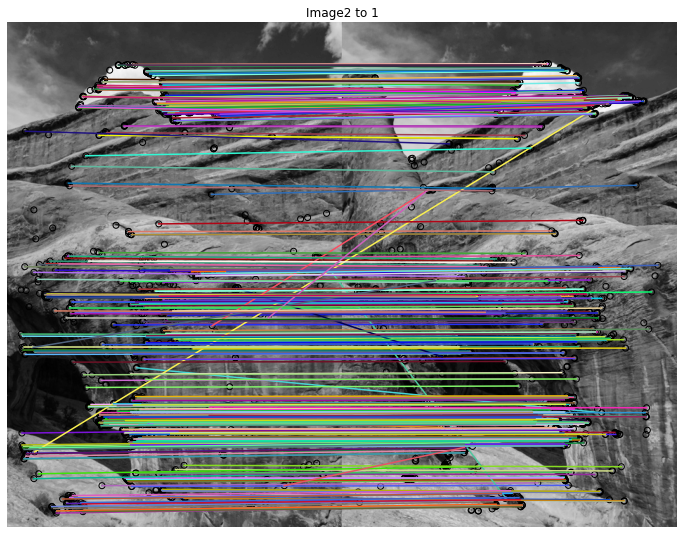

In [19]:
plt.figure(figsize=(12, 10))
plt.axis('off')
plt.gray()
plt.title('Image2 to 1')
ax = plt.gca()
plot_matches(ax, pano2, pano1, keypoints2, keypoints1, matches21)
plt.show()

There are obivious false positives in both images: For example, when we match image 0 to image 1, points at the bottom-left of image 0 are detected as matches to points at the top-right of image 1. These false positives result from rock patches that look somewhat alike.

Image features that produce good correspondences include edges, corners, and points that have high contrast to their surroundings. Examples include the boundary that separates the rock from the background sky.

# Homography + RANSAC

In [33]:
# skimage functions to look at:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

# opencv: cv2.findHomography with cv2.RANSAC

src = keypoints0[matches01[:, 0]][:, ::-1]
dst = keypoints1[matches01[:, 1]][:, ::-1]
model01, inliers01 = ransac(
    (src, dst), 
    ProjectiveTransform, 
    min_samples=4, residual_threshold=1, max_trials=300
)

src = keypoints2[matches21[:, 0]][:, ::-1]
dst = keypoints1[matches21[:, 1]][:, ::-1]
model21, inliers21 = ransac(
    (src, dst), 
    ProjectiveTransform, 
    min_samples=4, residual_threshold=1, max_trials=300
)

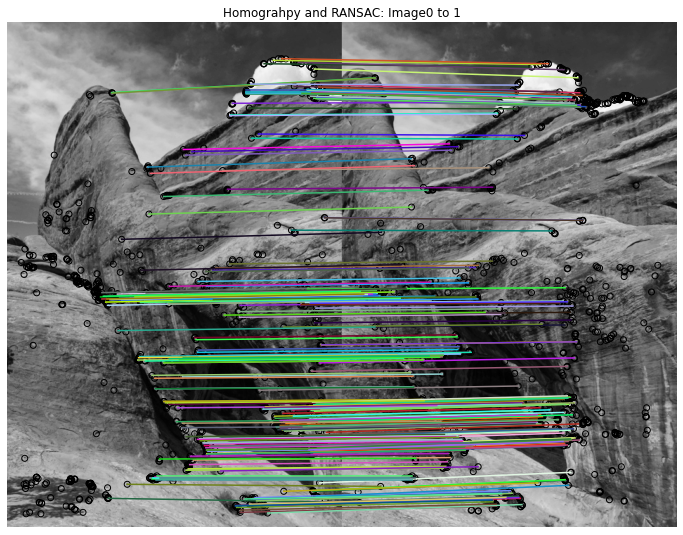

In [35]:
# plotting the inliers for homography estimation with ransac.
# looks much better!

plt.figure(figsize=(12, 10))
plt.axis('off')
plt.gray()
plt.title('Homograhpy and RANSAC: Image0 to 1')
ax = plt.gca()

plot_matches(ax, pano0, pano1, keypoints0, keypoints1, matches01[inliers01])
plt.show()

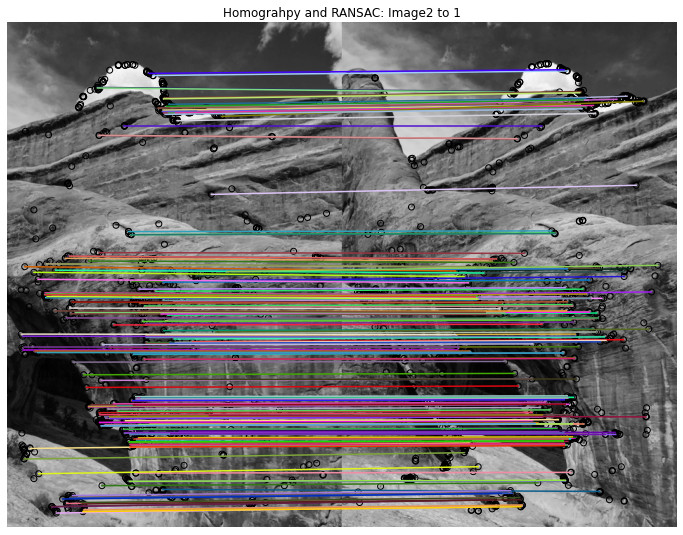

In [36]:
plt.figure(figsize=(12, 10))
plt.axis('off')
plt.gray()
plt.title('Homograhpy and RANSAC: Image2 to 1')
ax = plt.gca()

plot_matches(ax, pano2, pano1, keypoints2, keypoints1, matches21[inliers21])
plt.show()

The outliers have all been removed. There are no more lines crossing from one corner of one image to another corner of the other image. All matching line appear parallel.

# Panorama Warp


In [37]:
# Shape of middle image, our registration target
r, c = pano1.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions
warped_corners01 = model01(corners) # apply transform0->1 to corners
warped_corners12 = model21(corners) # apply transform1->2 to corners

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack((warped_corners01, warped_corners12, corners))

# The overall output shape will be max - min
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)

# Ensure integer shape with np.ceil and dtype conversion
output_shape = np.ceil(output_shape[::-1]).astype(int)
output_shape

array([822, 814])

### Applying the warps

In [43]:
from skimage.transform import warp
from skimage.transform import SimilarityTransform
from cv2 import warpAffine
from cv2 import warpPerspective


# Use one of the quantities computed above to find the correct offset for middle image
offset1 = SimilarityTransform(translation=-corner_min)

# Translate pano1 into place
# apply offset with an affine transform function, make sure the correct output_shape is specified
pano1_warped = warp(pano1, offset1.inverse, order=3, 
                    output_shape=output_shape, cval=-1)

# Get the validity mask for this image
pano1_mask = (pano1_warped != -1)
pano1_warped[~pano1_mask] = 0

In [44]:
# Warp the left image into place
transform01 = (model01 + offset1).inverse
pano0_warped = warp(pano0, transform01, order=3,
                   output_shape=output_shape, cval=-1)
pano0_mask = (pano0_warped != -1)
pano0_warped[~pano0_mask] = 0

In [45]:
# Warp the right image into place
transform21 = (model21 + offset1).inverse
pano2_warped = warp(pano2, transform21, order=3,
                   output_shape=output_shape, cval=-1)
pano2_mask = (pano2_warped != -1)
pano2_warped[~pano2_mask] = 0

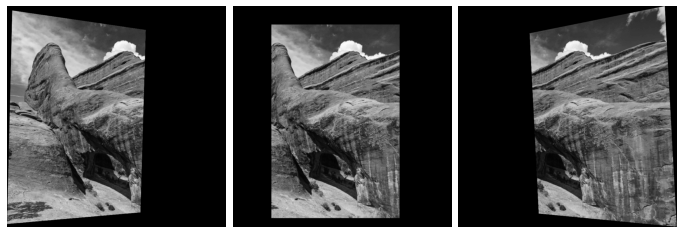

In [46]:
plot_imageset([pano0_warped, pano1_warped, pano2_warped])

# Blend images into panorama

In [53]:
# use [pano0_warped, pano1_warped, pano2_warped] and [pano0_mask, pano1_mask, pano2_mask]
# to obtain normalized panorama image

summed = pano0_warped + pano1_warped + pano2_warped
overlap = pano0_mask.astype(np.float32) + \
pano1_mask.astype(np.float32) + pano2_mask.astype(np.float32)
normalized = summed / np.maximum(overlap, 1)

(-0.5, 813.5, 821.5, -0.5)

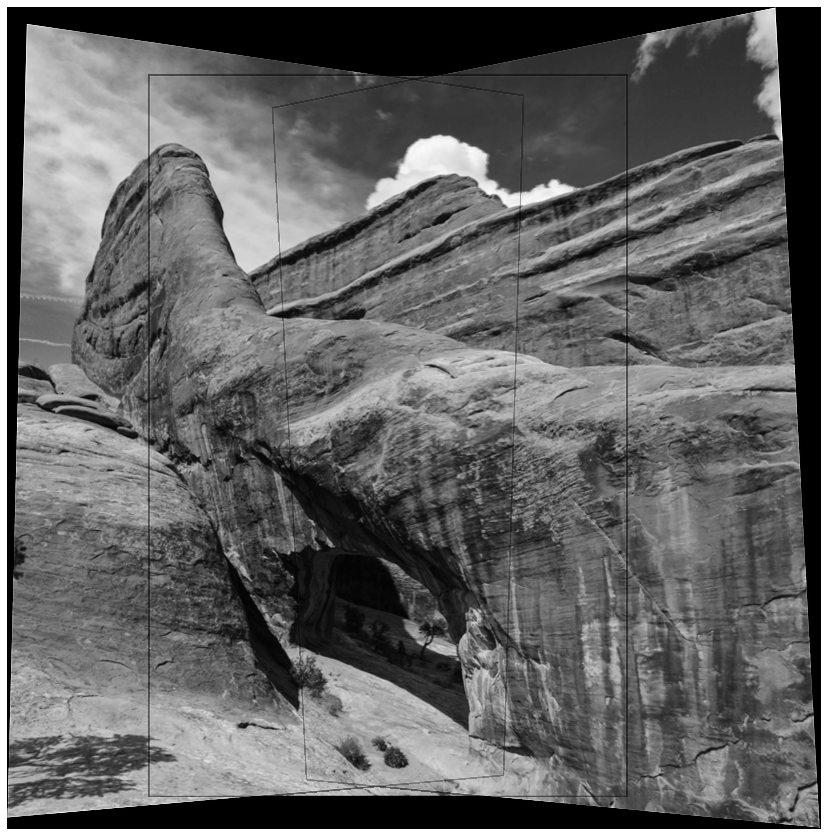

In [54]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(normalized, cmap='gray')

plt.tight_layout()
ax.axis('off')

(-0.5, 813.5, 821.5, -0.5)

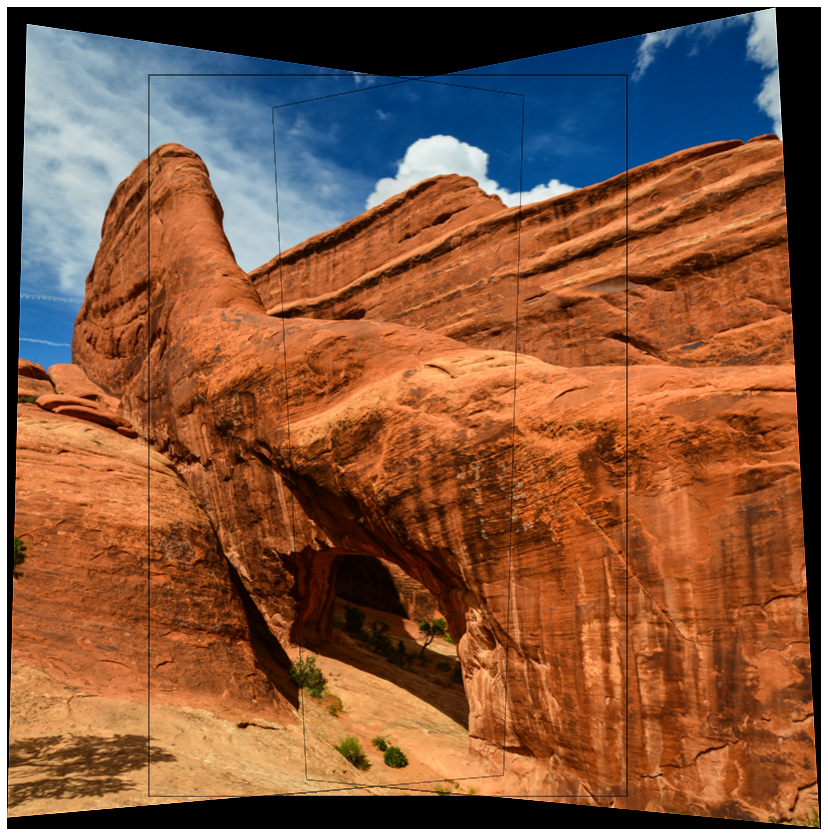

In [56]:
colorpano0, colorpano1, colorpano2 = pano_imgs

colorpano1_warped = warp(colorpano1, offset1.inverse, order=3, 
                    output_shape=output_shape, cval=-1)
colorpano1_mask = (colorpano1_warped != -1)
colorpano1_warped[~colorpano1_mask] = 0

colorpano0_warped = warp(colorpano0, transform01, order=3,
                   output_shape=output_shape, cval=-1)
colorpano0_mask = (colorpano0_warped != -1)
colorpano0_warped[~colorpano0_mask] = 0

colorpano2_warped = warp(colorpano2, transform21, order=3,
                   output_shape=output_shape, cval=-1)
colorpano2_mask = (colorpano2_warped != -1)
colorpano2_warped[~colorpano2_mask] = 0

summed = colorpano0_warped + colorpano1_warped + colorpano2_warped
overlap = colorpano0_mask.astype(np.float32) + \
colorpano1_mask.astype(np.float32) + colorpano2_mask.astype(np.float32)
normalized = summed / np.maximum(overlap, 1)

fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(normalized)

plt.tight_layout()
ax.axis('off')